In [1]:
# Load Package
import os
import numpy as np
import torch
from torchvision import datasets, models, transforms, utils
from scipy.special import softmax
from PIL import Image
from CWOX.IOX import IOX
from CWOX.CWOX_2s import CWOX_2s
from CWOX.plt_wox import plot_cwox

In [2]:
# Load Class_labels for ImageNet
import json
class_labels = json.load(open('resources/imagenet_class_index.json', 'r'))

In [3]:
# Load Image and Model
loader = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
img_path='eval_image//cello_guitar.jpg'
image = Image.open(img_path).convert('RGB')
image = loader(image).float()
image=torch.unsqueeze(image, 0)
model = models.resnet50(pretrained=True)
_ = model.train(False) # put model in evaluation mode

C:\Users\vaynexie\anaconda3\envs\py\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vaynexie\anaconda3\envs\py\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Make Prediction First
y_hat = softmax(model(image).data.numpy()[0])
top_5=np.argsort(y_hat)[::-1][:5]
for i in top_5:
    print([i,class_labels[str(i)][1],y_hat[i]])

[486, 'cello', 0.8355024]
[402, 'acoustic_guitar', 0.08424935]
[420, 'banjo', 0.03612492]
[889, 'violin', 0.020456413]
[546, 'electric_guitar', 0.008201507]


In [5]:
# Divide the Top 5 prediction classes into Confusion Clusters using learnt HLTM
from CWOX.apply_hltm import *
clusterify_resnet50 = apply_hltm(cut_level=0,json_path="resources/ResNet50.json")
cluster_use_final= clusterify_resnet50.get_cluster(top_5)
print(cluster_use_final)

[[486, 889], [402, 420, 546]]


## Grad-CAM

In [6]:
from CWOX.grad_cam_cwox import grad_cam_cwox

IOX_cluster=IOX(grad_cam_cwox(model,layer='layer4'))
IOX_class=IOX(grad_cam_cwox(model,layer='layer3.5.relu'))
sal_dict=CWOX_2s(image,cluster_use_final,cluster_method=IOX_cluster,class_method=IOX_class,delta=50,multiple_output=False)

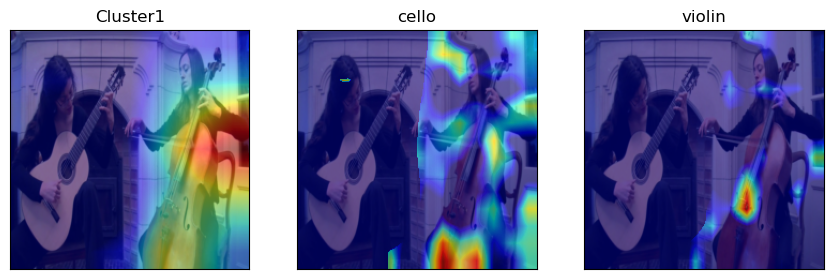

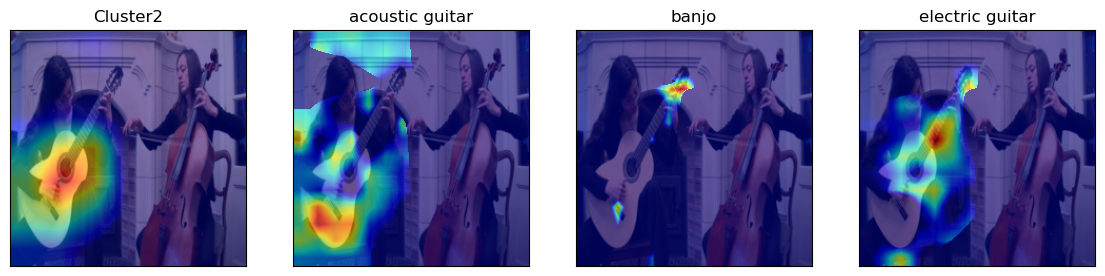

In [7]:
plot_cwox(sal_dict,image,cluster_use_final)

## MWP

In [8]:
# Update a ResNet model to use :class:`EltwiseSum` for the skip connection.
from CWOX.base_explainer.attribution.excitation_backprop import update_resnet
model_update=update_resnet(model)

from CWOX.excitationbackprop_cwox import excitationbackprop_cwox
IOX_cluster=IOX(excitationbackprop_cwox(model_update,layer='layer4'))
IOX_class=IOX(excitationbackprop_cwox(model_update,layer='layer4.0.relu'))
sal_dict=CWOX_2s(image,cluster_use_final,cluster_method=IOX_cluster,class_method=IOX_class,delta=60,multiple_output=False)

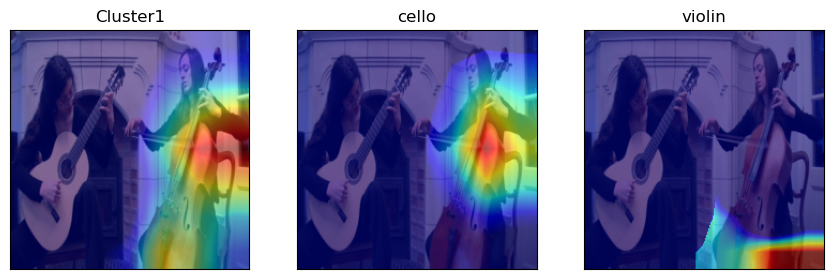

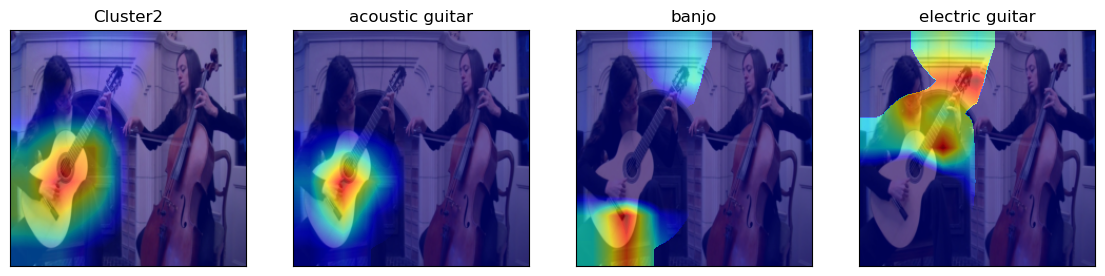

In [9]:
plot_cwox(sal_dict,image,cluster_use_final)

## RISE

In [18]:
from CWOX.base_explainer.attribution.rise import rise
from CWOX.rise_cwox import rise_cwox

IOX_cluster=IOX(rise_cwox(model,N=5000,mask_probability=0.3,down_sample_size=15,gpu_batch=30))
IOX_class=IOX(rise(model,N=3000,mask_probability=0.14,down_sample_size=10,gpu_batch=30))
sal_dict=CWOX_2s(image,cluster_use_final,cluster_method=IOX_cluster,class_method=IOX_class,delta=70,multiple_output=True)

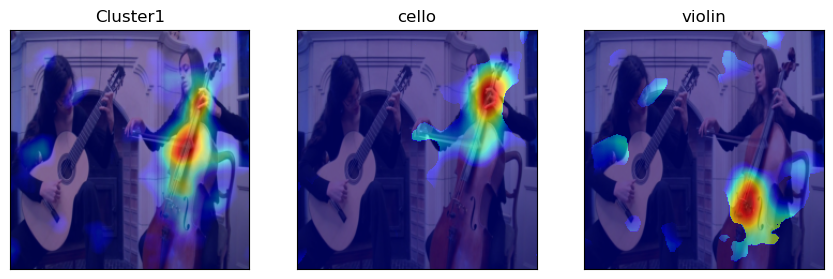

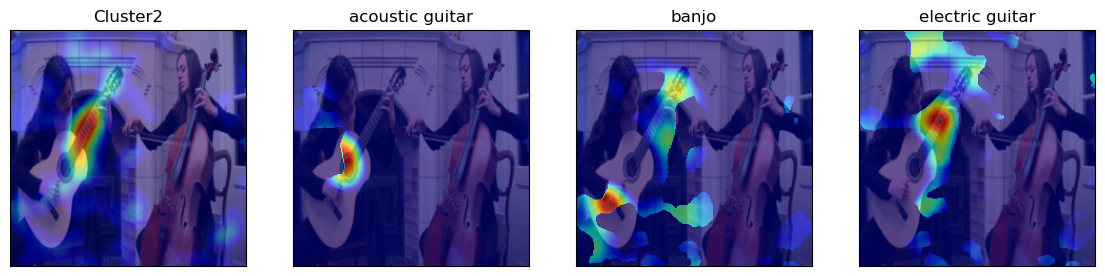

In [19]:
plot_cwox(sal_dict,image,cluster_use_final)

## LIME

In [22]:
from CWOX.base_explainer.attribution.lime import lime
from CWOX.lime_cwox import lime_cwox

IOX_cluster=IOX(lime_cwox(model,kernel_size=4,number_sample=2000,gpu_batch=100))
IOX_class=IOX(lime(model,kernel_size=4,number_sample=2000,gpu_batch=100))
sal_dict=CWOX_2s(img_path,cluster_use_final,cluster_method=IOX_cluster,class_method=IOX_class,delta=85,multiple_output=True)

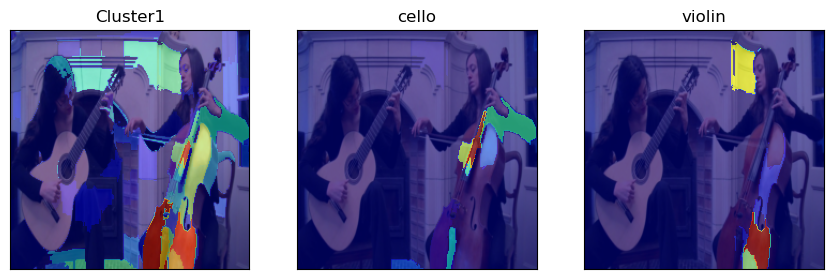

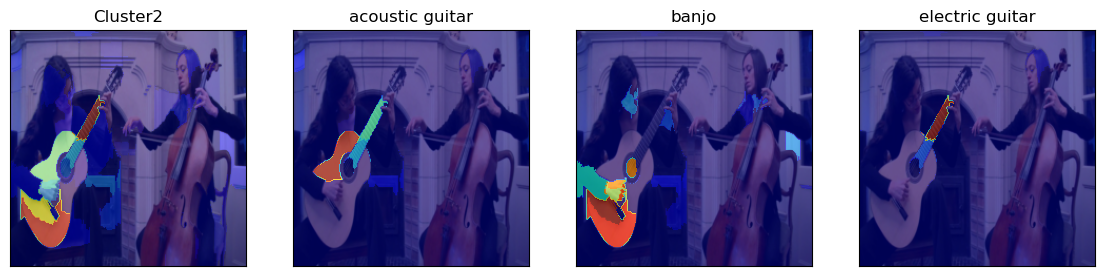

In [23]:
plot_cwox(sal_dict,image,cluster_use_final)